In [1]:
dataset_url = 'https://zenodo.org/records/7764556/files/cb513+profile_split1.npy.gz?download=1'

In [2]:
!pip install wget
import wget
file_name = wget.download(dataset_url)

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=806bc86a06a6b1171f765e2d02ab54db24679fa97827fce915c4f500cb8810a6
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [3]:
import numpy as np
data = np.load(file_name, allow_pickle=True)
data = data.reshape(514, 700, 57)

# in our dataset, features from 22 to 30 included represent the secondary
# structure label. We need to "group" them into 3 main cathegories

# data[:, :, 25] = data[:, :, 25] + data[:, :, 23] + data[:, :, 24]


/tmp/ipython-input-4123136231.py:2: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  data = np.load(file_name, allow_pickle=True)


In [4]:
! pip install py3Dmol

In [5]:
! pip install esm
! pip install fair-esm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

## Import Libraries

In [6]:
import esm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

✅ Libraries imported successfully
PyTorch version: 2.6.0+cu124
CUDA available: True
Using device: cuda


## Data Ingestion & Preprocessing

In [7]:
# TODO



In [8]:

def q8_to_q3(q8_onehot):
    N, L, _ = q8_onehot.shape

    q3_onehot = np.zeros((N, L, 4))

    # Map H (Helix)
    q3_onehot[:, :, 0] = q8_onehot[:, :, 3] + q8_onehot[:, :, 4] + q8_onehot[:, :, 5]
    # Map E (Strand)
    q3_onehot[:, :, 1] = q8_onehot[:, :, 1] + q8_onehot[:, :, 2]
    # Map C (Coil)
    q3_onehot[:, :, 2] = q8_onehot[:, :, 0] + q8_onehot[:, :, 6] + q8_onehot[:, :, 7]
    # NoSeq
    q3_onehot[:, :, 3] = q8_onehot[:, :, 8]

    return q3_onehot


In [9]:
q8_onehot = data[:, :, 22:31]  # Extract Q8 secondary structure features
q3_onehot = q8_to_q3(q8_onehot)

print('Q3 one-hot shape:', q3_onehot.shape)

# Remove Q8 slice (features 22 to 30)
before_q8 = data[:, :, :22]        # features before Q8
#after_q8 = data[:, :, 31:]         # features after Q8

# Concatenate before_q8 + q3_onehot + after_q8 along the features axis (axis=2)
data_q3 = np.concatenate([before_q8, q3_onehot], axis=2)

print('Original data shape:', data.shape)          # (514, 700, 57)
print('New data with Q3 shape:', data_q3.shape)    # (514, 700, 26)


Q3 one-hot shape: (514, 700, 4)
Original data shape: (514, 700, 57)
New data with Q3 shape: (514, 700, 26)


In [10]:
aa_order = ['A', 'C', 'E', 'D', 'G', 'F', 'I', 'H', 'K', 'M', 'L',
            'N', 'Q', 'P', 'S', 'R', 'T', 'W', 'V', 'Y', 'X', 'NoSeq']
ss_order = ['H', 'E', 'C', 'NoSeq']

def onehot_to_string_with_padding(onehot_array, order, noseq_index, pad_char):
    indices = np.argmax(onehot_array, axis=2)
    N, L = indices.shape
    strings = []
    for i in range(N):
        seq_chars = []
        for idx in indices[i]:
            if idx == noseq_index:
                seq_chars.append(pad_char)  # Replace NoSeq by pad_char
            else:
                seq_chars.append(order[idx])
        strings.append(''.join(seq_chars))
    return strings

# Example usage:
seq_strings = onehot_to_string_with_padding(data_q3[:, :, 0:22], aa_order, noseq_index=21, pad_char='X')
ss_strings = onehot_to_string_with_padding(data_q3[:, :, 22:26], ss_order, noseq_index=3, pad_char='-')


# seq_strings = data_q3[:, :, 0:22]
# ss_strings = data_q3[:, :, 22:26]


# Print a few examples:
for i in range(5):
    print(f"Sequence {i+1} (length 700):\n{seq_strings[i]}\n")
    print(f"Secondary Structure {i+1} (length 700):\n{ss_strings[i]}\n")


print ("sequence length:", len(seq_strings))
print("label length:", len(ss_strings))


Sequence 1 (length 700):
VPSLATISLENSWSGLSKQIQLAQGNNGIFRTPIVLVDNKGNRVQITNVTSKVVTSNIQLLLNTRNIXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

Secondary Structure 1 (length 700):
CCCHHHHHHHHHHHHHHHHHHHHCCCCCEEEEEEEECCCCCCCEEEEECCCHHHHHCECCECCHHHC--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

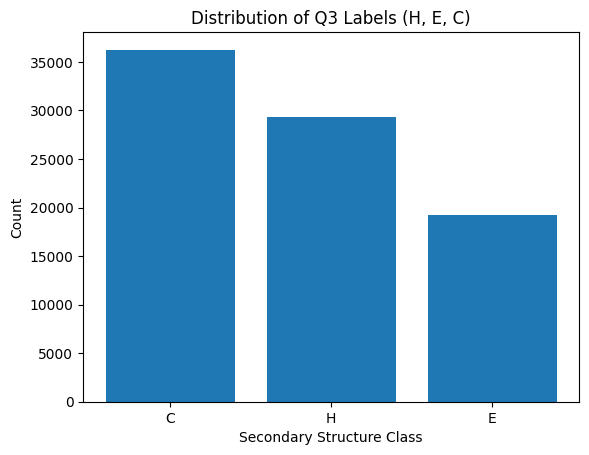

In [11]:
############### CLASS DISTRIBUTION ############################à
import matplotlib.pyplot as plt
from collections import Counter

# Flatten all labels into a single list
all_labels = ''.join(ss_strings).replace('-', '')  # remove padding

label_counts = Counter(all_labels)
classes = list(label_counts.keys())
counts = list(label_counts.values())

plt.bar(classes, counts)
plt.xlabel("Secondary Structure Class")
plt.ylabel("Count")
plt.title("Distribution of Q3 Labels (H, E, C)")
plt.show()


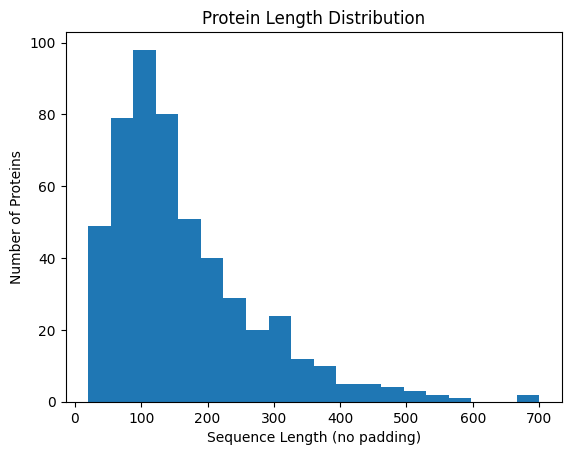

In [12]:
################## SEQUENCE LENGTH DISTRIBUTION ###########################
seq_lengths = [len(seq.replace('X', '')) for seq in seq_strings]

plt.hist(seq_lengths, bins=20)
plt.xlabel("Sequence Length (no padding)")
plt.ylabel("Number of Proteins")
plt.title("Protein Length Distribution")
plt.show()


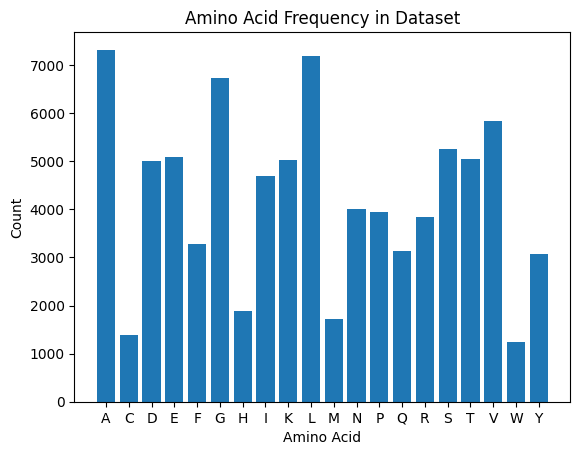

In [13]:
####################### AMINO ACID FREQUENCY DISTRIBUTION #################àà
aa_counts = Counter(''.join(seq_strings).replace('X', ''))
aa, counts = zip(*sorted(aa_counts.items()))

plt.bar(aa, counts)
plt.xlabel("Amino Acid")
plt.ylabel("Count")
plt.title("Amino Acid Frequency in Dataset")
plt.show()


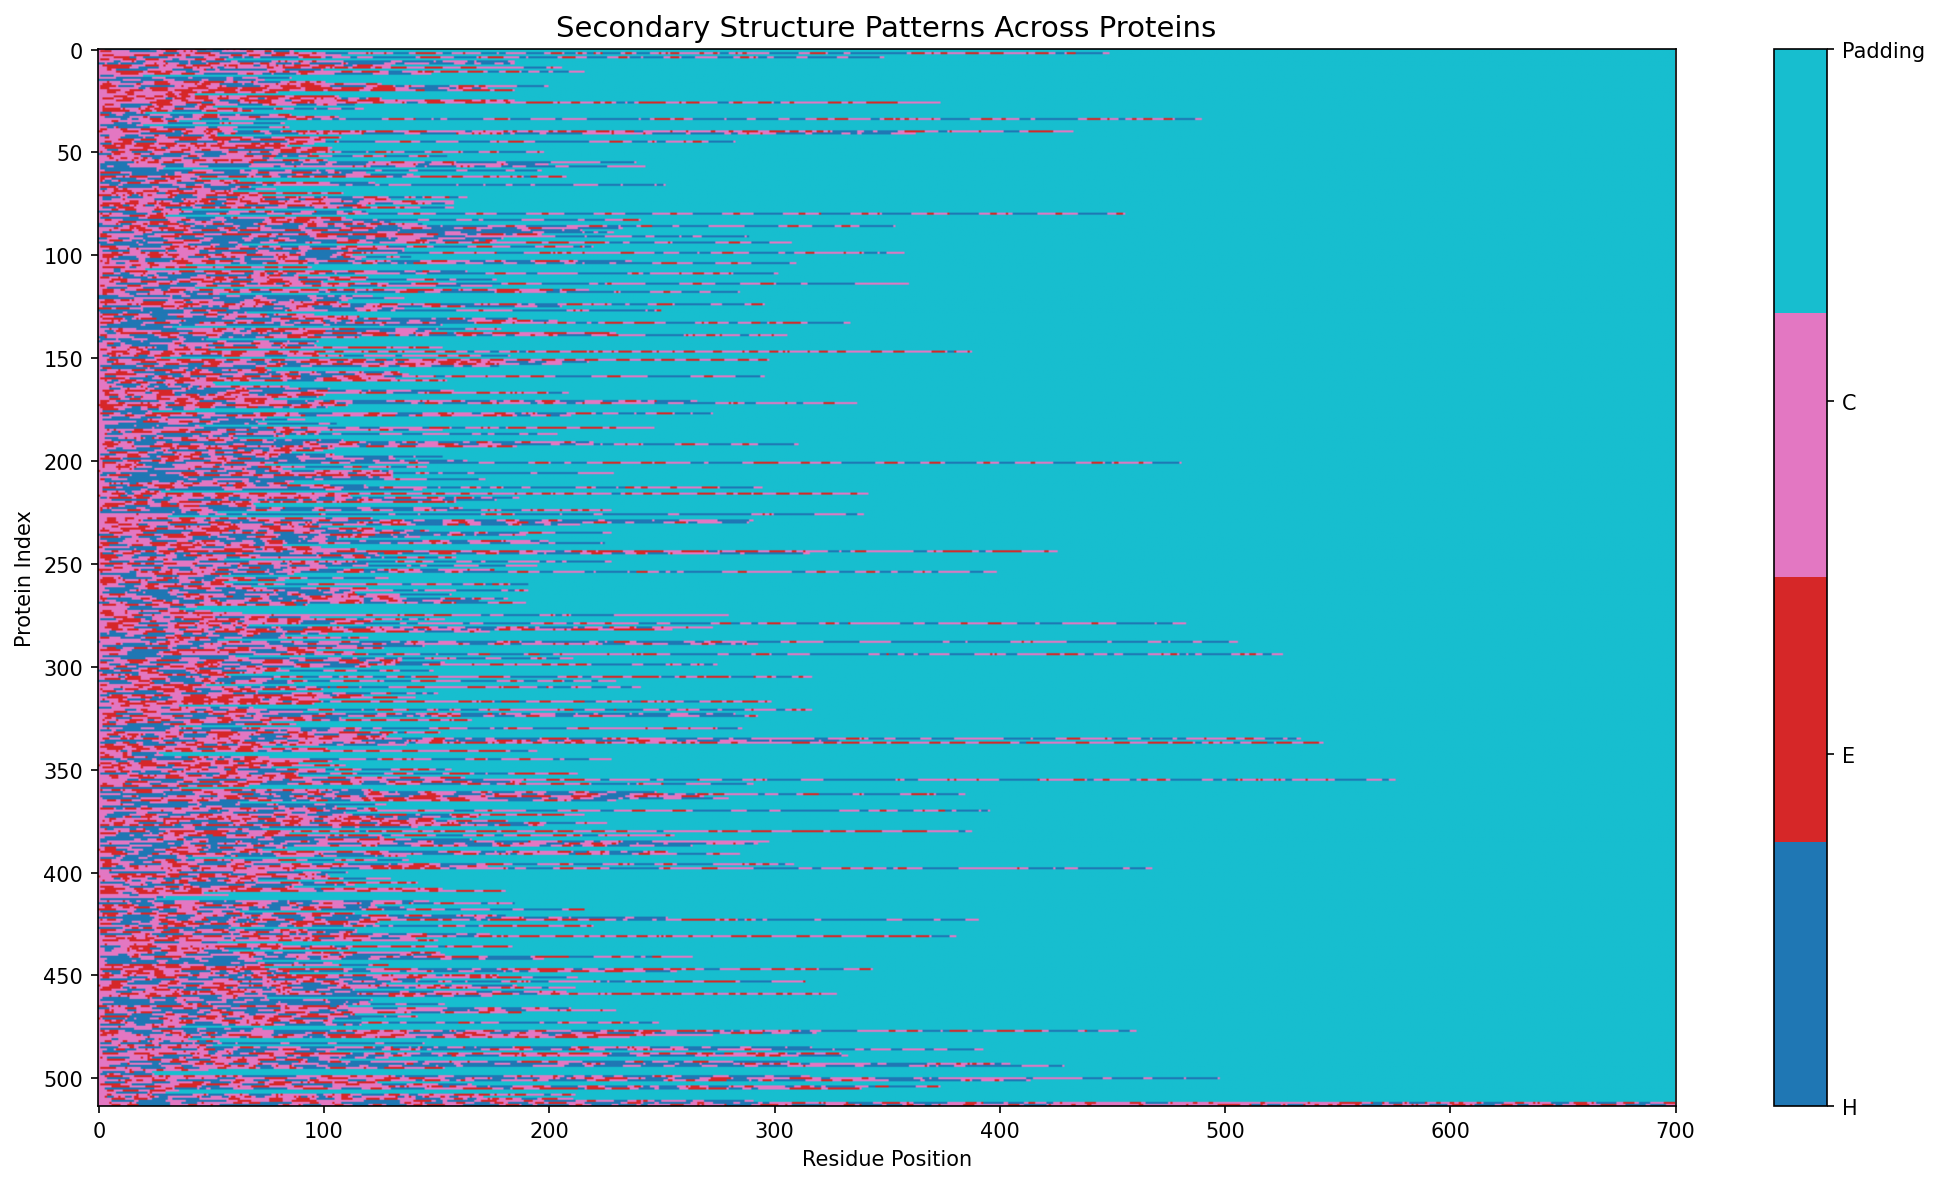

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Map Q3 to integers
mapping = {'H': 0, 'E': 1, 'C': 2, '-': 3}
label_array = np.array([[mapping[c] for c in s] for s in ss_strings])

# Plot
fig, ax = plt.subplots(figsize=(14, 8), dpi=150)
cmap = plt.get_cmap('tab10', 4)  # 4 discrete colors

im = ax.imshow(label_array, aspect='auto', cmap=cmap)

# Add colorbar with class names
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1, 2, 3])
cbar.ax.set_yticklabels(['H', 'E', 'C', 'Padding'])

ax.set_title("Secondary Structure Patterns Across Proteins", fontsize=14)
ax.set_xlabel("Residue Position")
ax.set_ylabel("Protein Index")

ax.set_xticks(range(0, 701, 100))
ax.set_yticks(range(0, len(ss_strings), 50))

plt.tight_layout()
plt.show()


## Model Training

In [15]:
# TODO

In [16]:
print("🔄 Loading ESM-2 model...")
model_esm, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
batch_converter = alphabet.get_batch_converter()
model_esm.eval()
model_esm = model_esm.to(device)

# Get embedding dimension by checking the model's embed_tokens layer
embedding_dim = model_esm.embed_tokens.embedding_dim

print("✅ ESM-2 model loaded successfully")
print(f"Model layers: {model_esm.num_layers}")
print(f"Embedding dimension: {embedding_dim}")

# Freeze ESM-2 parameters (we only train the classifier)
for param in model_esm.parameters():
    param.requires_grad = False

print("🔒 ESM-2 parameters frozen for transfer learning")

🔄 Loading ESM-2 model...


Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t6_8M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t6_8M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D-contact-regression.pt


✅ ESM-2 model loaded successfully
Model layers: 6
Embedding dimension: 320
🔒 ESM-2 parameters frozen for transfer learning


In [17]:
class ProteinSSDataset(Dataset):
    def __init__(self, sequences, labels, alphabet, max_len=700):
        """
        sequences: list of protein sequences
        labels: list of secondary structure labels (same length as sequences)
        alphabet: ESM alphabet for tokenization
        max_len: maximum sequence length (pad/truncate to this)
        """
        self.sequences = sequences
        self.labels = labels
        self.alphabet = alphabet
        self.max_len = max_len
        self.batch_converter = alphabet.get_batch_converter()

        # Secondary structure mapping
        self.ss_to_idx = {'H': 0, 'E': 1, 'C': 2}  # Helix, Sheet, Coil
        self.idx_to_ss = {0: 'H', 1: 'E', 2: 'C'}

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        ss_labels = self.labels[idx]

        # Ensure sequence and labels are same length
        min_len = min(len(sequence), len(ss_labels), self.max_len)
        sequence = sequence[:min_len]
        ss_labels = ss_labels[:min_len]

        # Pad sequence if needed
        if len(sequence) < self.max_len:
            sequence = sequence + 'X' * (self.max_len - len(sequence))
            ss_labels = ss_labels + 'C' * (self.max_len - len(ss_labels))

        # Convert SS labels to indices
        label_indices = [self.ss_to_idx.get(ss, 2) for ss in ss_labels]  # Default to Coil

        return sequence, torch.tensor(label_indices, dtype=torch.long)

print("✅ Dataset class defined")
print("Secondary structure mapping:", {'H': 'Helix', 'E': 'Sheet', 'C': 'Coil'})

✅ Dataset class defined
Secondary structure mapping: {'H': 'Helix', 'E': 'Sheet', 'C': 'Coil'}


In [18]:
class ProteinSSClassifier(nn.Module):
    def __init__(self, esm_dim=320, hidden_dim=256, num_classes=3, dropout=0.3):
        super().__init__()
        self.bilstm = nn.LSTM(esm_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, esm_embeddings):
        x, _ = self.bilstm(esm_embeddings)   # (batch, seq_len, hidden_dim*2)
        return self.classifier(x)

print("✅ Classifier model defined")
print("Architecture: ESM embeddings -> Hidden layers -> 3 classes (H/E/C)")


✅ Classifier model defined
Architecture: ESM embeddings -> Hidden layers -> 3 classes (H/E/C)


In [19]:
from sklearn.model_selection import train_test_split

print(f"✅ Dataset loaded:")
print(f"Total samples: {len(seq_strings)}")
print(f"Sequence length: {len(seq_strings[0])}")

# Split dataset: 70% train, 15% val, 15% test
print("🔄 Splitting dataset...")

# First split: separate test set (15%)
train_val_sequences, test_sequences, train_val_labels, test_labels = train_test_split(
    seq_strings, ss_strings,
    test_size=0.15,
    random_state=42,
    stratify=None  # Remove if you want to stratify by some criterion
)

# Second split: separate train and validation from remaining 85%
train_sequences, val_sequences, train_labels, val_labels = train_test_split(
    train_val_sequences, train_val_labels,
    test_size=0.176,  # 0.15/0.85 ≈ 0.176 to get 15% of total for validation
    random_state=42,
    stratify=None
)

print(f"✅ Dataset split completed:")
print(f"Training samples: {len(train_sequences)} ({len(train_sequences)/len(seq_strings)*100:.1f}%)")
print(f"Validation samples: {len(val_sequences)} ({len(val_sequences)/len(seq_strings)*100:.1f}%)")
print(f"Test samples: {len(test_sequences)} ({len(test_sequences)/len(seq_strings)*100:.1f}%)")
print(f"Total: {len(train_sequences) + len(val_sequences) + len(test_sequences)}")

# Data quality checks
print(f"\n🔍 Data quality checks:")
print(f"First sequence preview: {train_sequences[0][:50]}...")
print(f"First SS labels preview: {train_labels[0][:50]}...")
print(f"Sequence length consistency: {len(set(len(seq) for seq in train_sequences))} unique lengths")
print(f"SS length consistency: {len(set(len(ss) for ss in train_labels))} unique lengths")

# Check for valid characters
valid_aa = set('ACDEFGHIKLMNPQRSTVWYX')
valid_ss = set('HEC')

seq_chars = set(''.join(train_sequences))
ss_chars = set(''.join(train_labels))

print(f"Sequence characters found: {sorted(seq_chars)}")
print(f"SS characters found: {sorted(ss_chars)}")
print(f"Invalid AA chars: {seq_chars - valid_aa}")
print(f"Invalid SS chars: {ss_chars - valid_ss}")

✅ Dataset loaded:
Total samples: 514
Sequence length: 700
🔄 Splitting dataset...
✅ Dataset split completed:
Training samples: 359 (69.8%)
Validation samples: 77 (15.0%)
Test samples: 78 (15.2%)
Total: 514

🔍 Data quality checks:
First sequence preview: TYTTRQIGAKNTLEYKVYIEKDGKPVSAFHDIPLYADKEDNIFNMVVEIP...
First SS labels preview: CCCEEEECCCCCCCCEEEEECCCCECCCCCCCCCCCCCCCCCCCECCCCC...
Sequence length consistency: 1 unique lengths
SS length consistency: 1 unique lengths
Sequence characters found: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'X', 'Y']
SS characters found: ['-', 'C', 'E', 'H']
Invalid AA chars: set()
Invalid SS chars: {'-'}


In [20]:
train_dataset = ProteinSSDataset(train_sequences, train_labels, alphabet)
val_dataset = ProteinSSDataset(val_sequences, val_labels, alphabet)

batch_size = 4  # Small batch size for 700-length sequences
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("✅ Data loaders created")
print(f"Batch size: {batch_size}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

# Test data loading
sample_batch = next(iter(train_loader))
print(f"Sample batch - sequences: {len(sample_batch[0])}, labels shape: {sample_batch[1].shape}")


✅ Data loaders created
Batch size: 4
Training batches: 90
Validation batches: 20
Sample batch - sequences: 4, labels shape: torch.Size([4, 700])


In [21]:
# Initialize classifier
classifier = ProteinSSClassifier(esm_dim=embedding_dim).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=-1)  # Ignore padding tokens
optimizer = optim.AdamW(classifier.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

print("✅ Training setup complete")
print(f"Classifier parameters: {sum(p.numel() for p in classifier.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in classifier.parameters() if p.requires_grad):,}")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")


✅ Training setup complete
Classifier parameters: 1,315,843
Trainable parameters: 1,315,843
Learning rate: 0.001


In [22]:
def get_esm_embeddings(sequences, model_esm, batch_converter, device):
    """Extract ESM-2 embeddings for a batch of sequences"""
    # Prepare data for ESM
    data = [(f"seq_{i}", seq) for i, seq in enumerate(sequences)]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    batch_tokens = batch_tokens.to(device)

    with torch.no_grad():
        results = model_esm(batch_tokens, repr_layers=[model_esm.num_layers])
        embeddings = results["representations"][model_esm.num_layers]

    # Remove special tokens (CLS and SEP)
    embeddings = embeddings[:, 1:-1, :]  # Remove first and last tokens
    return embeddings

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_predictions = []
    all_labels = []

    pbar = tqdm(train_loader, desc="Training")
    for batch_idx, (sequences, labels) in enumerate(pbar):
        labels = labels.to(device)

        # Get ESM embeddings
        embeddings = get_esm_embeddings(sequences, model_esm, batch_converter, device)

        # Ensure embeddings and labels have same sequence length
        min_len = min(embeddings.size(1), labels.size(1))
        embeddings = embeddings[:, :min_len, :]
        labels = labels[:, :min_len]

        # Forward pass
        optimizer.zero_grad()
        outputs = model(embeddings)

        # Reshape for loss calculation
        outputs_flat = outputs.view(-1, outputs.size(-1))
        labels_flat = labels.view(-1)

        loss = criterion(outputs_flat, labels_flat)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Collect predictions for metrics
        predictions = torch.argmax(outputs, dim=-1)
        all_predictions.extend(predictions.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

        pbar.set_postfix({'loss': f"{loss.item():.4f}"})

    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_predictions)

    return avg_loss, accuracy

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(val_loader, desc="Validation")
        for sequences, labels in pbar:
            labels = labels.to(device)

            # Get ESM embeddings
            embeddings = get_esm_embeddings(sequences, model_esm, batch_converter, device)

            # Ensure embeddings and labels have same sequence length
            min_len = min(embeddings.size(1), labels.size(1))
            embeddings = embeddings[:, :min_len, :]
            labels = labels[:, :min_len]

            # Forward pass
            outputs = model(embeddings)

            # Reshape for loss calculation
            outputs_flat = outputs.view(-1, outputs.size(-1))
            labels_flat = labels.view(-1)

            loss = criterion(outputs_flat, labels_flat)
            total_loss += loss.item()

            # Collect predictions for metrics
            predictions = torch.argmax(outputs, dim=-1)
            all_predictions.extend(predictions.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

            pbar.set_postfix({'loss': f"{loss.item():.4f}"})

    avg_loss = total_loss / len(val_loader)
    accuracy = accuracy_score(all_labels, all_predictions)

    return avg_loss, accuracy, all_predictions, all_labels

print("✅ Training functions defined")


✅ Training functions defined


In [23]:
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print("🚀 Starting training...")
print(f"Training for {num_epochs} epochs")
print("=" * 60)

best_val_acc = 0
best_model_state = None

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 40)

    # Training
    train_loss, train_acc = train_epoch(classifier, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    val_loss, val_acc, val_preds, val_true = validate_epoch(classifier, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = classifier.state_dict().copy()
        print("💾 New best model saved!")

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

print("\n" + "=" * 60)
print("🎉 Training completed!")
print(f"Best validation accuracy: {best_val_acc:.4f}")

# Load best model
classifier.load_state_dict(best_model_state)


🚀 Starting training...
Training for 10 epochs

Epoch 1/10
----------------------------------------


Validation: 100%|██████████| 20/20 [00:01<00:00, 11.47it/s, loss=0.2553]


💾 New best model saved!
Train Loss: 0.2150, Train Acc: 0.9066
Val Loss: 0.1848, Val Acc: 0.9240
Learning Rate: 0.001000

Epoch 2/10
----------------------------------------


Validation: 100%|██████████| 20/20 [00:01<00:00, 10.80it/s, loss=0.2324]


💾 New best model saved!
Train Loss: 0.1426, Train Acc: 0.9410
Val Loss: 0.1829, Val Acc: 0.9249
Learning Rate: 0.001000

Epoch 3/10
----------------------------------------


Validation: 100%|██████████| 20/20 [00:01<00:00, 10.96it/s, loss=0.2293]


💾 New best model saved!
Train Loss: 0.1383, Train Acc: 0.9425
Val Loss: 0.1776, Val Acc: 0.9270
Learning Rate: 0.001000

Epoch 4/10
----------------------------------------


Validation: 100%|██████████| 20/20 [00:01<00:00, 11.58it/s, loss=0.2335]


💾 New best model saved!
Train Loss: 0.1321, Train Acc: 0.9448
Val Loss: 0.1773, Val Acc: 0.9280
Learning Rate: 0.001000

Epoch 5/10
----------------------------------------


Validation: 100%|██████████| 20/20 [00:01<00:00, 11.33it/s, loss=0.2341]


💾 New best model saved!
Train Loss: 0.1292, Train Acc: 0.9464
Val Loss: 0.1762, Val Acc: 0.9285
Learning Rate: 0.001000

Epoch 6/10
----------------------------------------


Validation: 100%|██████████| 20/20 [00:01<00:00, 11.89it/s, loss=0.2441]


Train Loss: 0.1256, Train Acc: 0.9476
Val Loss: 0.1834, Val Acc: 0.9273
Learning Rate: 0.001000

Epoch 7/10
----------------------------------------


Validation: 100%|██████████| 20/20 [00:01<00:00, 11.79it/s, loss=0.2339]


Train Loss: 0.1217, Train Acc: 0.9492
Val Loss: 0.1880, Val Acc: 0.9253
Learning Rate: 0.001000

Epoch 8/10
----------------------------------------


Validation: 100%|██████████| 20/20 [00:01<00:00, 11.73it/s, loss=0.2426]


Train Loss: 0.1178, Train Acc: 0.9503
Val Loss: 0.1859, Val Acc: 0.9265
Learning Rate: 0.001000

Epoch 9/10
----------------------------------------


Validation: 100%|██████████| 20/20 [00:01<00:00, 11.73it/s, loss=0.2514]


Train Loss: 0.1133, Train Acc: 0.9524
Val Loss: 0.1854, Val Acc: 0.9258
Learning Rate: 0.000500

Epoch 10/10
----------------------------------------


Validation: 100%|██████████| 20/20 [00:01<00:00, 11.68it/s, loss=0.2539]

Train Loss: 0.1034, Train Acc: 0.9566
Val Loss: 0.1980, Val Acc: 0.9247
Learning Rate: 0.000500

🎉 Training completed!
Best validation accuracy: 0.9285


<All keys matched successfully>

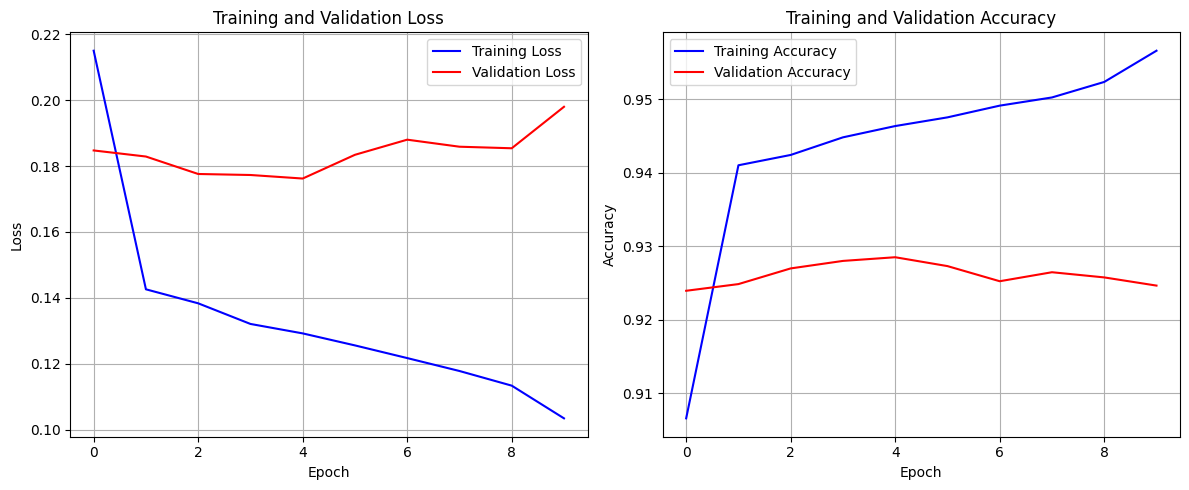

📊 Training history plotted


In [24]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("📊 Training history plotted")


In [25]:
print("🔍 Detailed Validation Analysis")
print("=" * 50)

# Get final validation predictions
_, _, final_val_preds, final_val_true = validate_epoch(classifier, val_loader, criterion, device)

# Classification report
ss_names = ['Helix (H)', 'Sheet (E)', 'Coil (C)']
print("\nClassification Report:")
print(classification_report(final_val_true, final_val_preds, target_names=ss_names))

# Confusion matrix
cm = confusion_matrix(final_val_true, final_val_preds)
print("\nConfusion Matrix:")
print("           Predicted")
print("         H    E    C")
for i, true_label in enumerate(['H', 'E', 'C']):
    print(f"True {true_label} {cm[i]}")

# Class-wise accuracy
for i, class_name in enumerate(ss_names):
    class_acc = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    print(f"{class_name} accuracy: {class_acc:.4f}")

🔍 Detailed Validation Analysis


Validation: 100%|██████████| 20/20 [00:01<00:00, 11.52it/s, loss=0.2539]



Classification Report:
              precision    recall  f1-score   support

   Helix (H)       0.76      0.80      0.78      5297
   Sheet (E)       0.72      0.63      0.67      3429
    Coil (C)       0.96      0.96      0.96     45174

    accuracy                           0.92     53900
   macro avg       0.81      0.80      0.80     53900
weighted avg       0.92      0.92      0.92     53900


Confusion Matrix:
           Predicted
         H    E    C
True H [4238  170  889]
True E [ 280 2161  988]
True C [ 1077   656 43441]
Helix (H) accuracy: 0.8001
Sheet (E) accuracy: 0.6302
Coil (C) accuracy: 0.9616


In [26]:
def predict_secondary_structure(sequence, model_esm, classifier, batch_converter, device):
    """Predict secondary structure for a single protein sequence"""
    classifier.eval()

    # Prepare sequence
    data = [("input_seq", sequence)]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    batch_tokens = batch_tokens.to(device)

    with torch.no_grad():
        # Get ESM embeddings
        results = model_esm(batch_tokens, repr_layers=[model_esm.num_layers])
        embeddings = results["representations"][model_esm.num_layers]
        embeddings = embeddings[:, 1:-1, :]  # Remove special tokens

        # Get predictions
        outputs = classifier(embeddings)
        predictions = torch.argmax(outputs, dim=-1)

        # Convert to letters
        ss_map = {0: 'H', 1: 'E', 2: 'C'}
        predicted_ss = ''.join([ss_map[int(pred)] for pred in predictions[0]])

        # Get confidence scores
        probs = torch.softmax(outputs, dim=-1)
        confidence = torch.max(probs, dim=-1)[0].mean().item()

    return predicted_ss, confidence

# Example prediction
print("🧬 Example Prediction")
print("=" * 30)

test_sequence = train_sequences[4][:100]  # Use first 100 residues for demo
true_ss = train_labels[4][:100]

predicted_ss, confidence = predict_secondary_structure(test_sequence, model_esm, classifier, batch_converter, device)

print(f"Sequence:  {test_sequence}")
print(f"True SS:   {true_ss}")
print(f"Predicted: {predicted_ss}")
print(f"Confidence: {confidence:.4f}")

# Calculate accuracy for this example
example_acc = sum(1 for t, p in zip(true_ss, predicted_ss) if t == p) / len(true_ss)
print(f"Example accuracy: {example_acc:.4f}")


🧬 Example Prediction
Sequence:  MEHVAFGSEDIENTLAKMDDGQLDGLAFGAIQLDGDGNILQYNAAEGDITGRDPKQVIGKNFFKDVAPCTDSPEFYGKFKEGVASGNLNTMFEYTFDYQM
True SS:   CCCCCCCCCCHHHHHCCCCHHHHCCCCCEEEEEECCCEEEEECHHHHHHHCCCHHHHCCCEHHHHHCHHHCCCCCHHHHHHHHHHCCCEEEEEEEECCCC
Predicted: CCCCCCCCHHHHHHHHCCCHHHHHCCCCEEEEEECCCEEEEECHHHHHHHCCCHHHHCCCEHHHHHCCHCCCHHHHHHHHHHHHHCCCEEEEEEEECCCC
Confidence: 0.8493
Example accuracy: 0.9100


### Download Classifier

In [27]:

# Uncomment to save the trained model
"""
torch.save({
    'model_state_dict': classifier.state_dict(),
    'model_config': {
        'esm_dim': embedding_dim,
        'hidden_dim': 128,
        'num_classes': 3,
        'dropout': 0.3
    },
    'training_history': {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'best_val_acc': best_val_acc
    }
}, 'protein_ss_classifier.pth')

print("💾 Model saved as 'protein_ss_classifier.pth'")
"""

'\ntorch.save({\n    \'model_state_dict\': classifier.state_dict(),\n    \'model_config\': {\n        \'esm_dim\': embedding_dim,\n        \'hidden_dim\': 128,\n        \'num_classes\': 3,\n        \'dropout\': 0.3\n    },\n    \'training_history\': {\n        \'train_losses\': train_losses,\n        \'val_losses\': val_losses,\n        \'train_accuracies\': train_accuracies,\n        \'val_accuracies\': val_accuracies,\n        \'best_val_acc\': best_val_acc\n    }\n}, \'protein_ss_classifier.pth\')\n\nprint("💾 Model saved as \'protein_ss_classifier.pth\'")\n'

## Evaluation & Visualization

In [28]:
# TODO

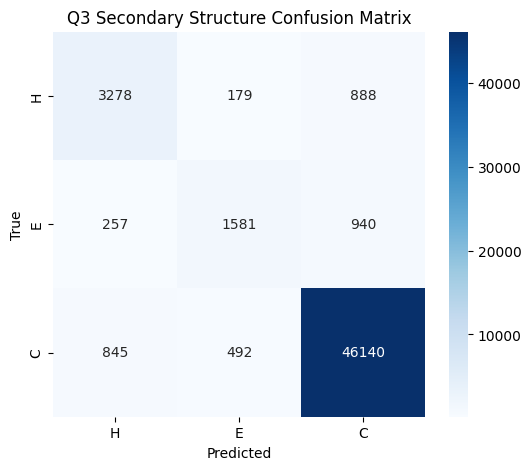

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict on test set
test_dataset = ProteinSSDataset(test_sequences, test_labels, alphabet)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

all_preds, all_true = [], []
classifier.eval()
with torch.no_grad():
    for seqs, labels in test_loader:
        embeddings = get_esm_embeddings(seqs, model_esm, batch_converter, device)
        outputs = classifier(embeddings)
        preds = torch.argmax(outputs, dim=-1).cpu().numpy()
        all_preds.extend(preds.flatten())
        all_true.extend(labels.numpy().flatten())

# Confusion matrix
cm = confusion_matrix(all_true, all_preds, labels=[0,1,2])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['H','E','C'], yticklabels=['H','E','C'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Q3 Secondary Structure Confusion Matrix')
plt.show()


In [30]:
import py3Dmol
from Bio.PDB import PDBParser

def visualize_structure_with_prediction(pdb_id, chain_id, predicted_ss):
    view = py3Dmol.view(query='pdb:' + pdb_id)
    colors = {'H': 'red', 'E': 'yellow', 'C': 'green'}

    # For each residue, apply color from predicted_ss
    for i, ss in enumerate(predicted_ss):
        color = colors.get(ss, 'white')
        view.setStyle({'chain': chain_id, 'resi': str(i+1)},
                      {'cartoon': {'color': color}})
    view.show()


In [31]:
test_sequence = "KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSRNLCNIPCSALLSSDITASVNCAKKIVSDGNGMNAWVAWRNRCKGTDVQAWIRGCRL"
true_ss =       "CCCCCHHHHHHHHHHHHCCCCCCCCCCHHHHHHHHHHHHHHHHCCCCCCCHHHHHHHHHHHCCCCCCCCCCCCCHHHHHHHHHHCCCCCCCCCCCCCCCCCHHHHHHHHHHHHHHHHHCCCCCCCHHHH"

predicted_ss, confidence = predict_secondary_structure(test_sequence, model_esm, classifier, batch_converter, device)

print(f"Sequence:  {test_sequence}")
print(f"True SS:   {true_ss}")
print(f"Predicted: {predicted_ss}")
print(f"Confidence: {confidence:.4f}")

# Calculate accuracy for this example
example_acc = sum(1 for t, p in zip(true_ss, predicted_ss) if t == p) / len(true_ss)
print(f"Example accuracy: {example_acc:.4f}")

Sequence:  KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSRNLCNIPCSALLSSDITASVNCAKKIVSDGNGMNAWVAWRNRCKGTDVQAWIRGCRL
True SS:   CCCCCHHHHHHHHHHHHCCCCCCCCCCHHHHHHHHHHHHHHHHCCCCCCCHHHHHHHHHHHCCCCCCCCCCCCCHHHHHHHHHHCCCCCCCCCCCCCCCCCHHHHHHHHHHHHHHHHHCCCCCCCHHHH
Predicted: CCCCHHHHHHHHHHHCCCCHHHHHHHHHHHHHHHHHHHHHCCCCCCCCCCCHHHHHHHHCHEEECCCCCCCCHHHHCCCHHHHHHCCHHHHHHHHHHHHHCCCHHHHHHHHHHHCCHHHHHHHHHHCCC
Confidence: 0.6823
Example accuracy: 0.5969


In [32]:
# Example:
pred_ss, _ = predict_secondary_structure(test_sequence, model_esm, classifier, batch_converter, device)
visualize_structure_with_prediction('1LZH', 'C', true_ss)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [33]:
# Example:
pred_ss, _ = predict_secondary_structure(test_sequence, model_esm, classifier, batch_converter, device)
visualize_structure_with_prediction('1L2Y', 'A', pred_ss)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [34]:
import py3Dmol
from IPython.display import display, HTML

def create_ss_view(pdb_id, chain_id, ss, title):
    colors = {'H': '#00FFFF',  # aqua blue
              'C': '#8A2BE2',  # violet
              'E': '#000080'}  # navy blue
    view = py3Dmol.view(query='pdb:' + pdb_id, width=400, height=400)
    for i, ss_char in enumerate(ss):
        color = colors.get(ss_char, '#FFFFFF')  # fallback white
        view.setStyle({'chain': chain_id, 'resi': str(i+1)},
                      {'cartoon': {'color': color}})
    view.setBackgroundColor('0xeeeeee')
    view.zoomTo()
    html = view._make_html()
    html_with_caption = f"<div style='text-align:center'>{html}<div style='font-weight:bold; margin-top:5px'>{title}</div></div>"
    return html_with_caption

def create_diff_view(pdb_id, chain_id, true_ss, pred_ss, title):
    view = py3Dmol.view(query='pdb:' + pdb_id, width=400, height=400)
    for i, (t, p) in enumerate(zip(true_ss, pred_ss)):
        color = '#D3D3D3' if t == p else '#FF007F'  # light grey if same, light blue if diff
        view.setStyle({'chain': chain_id, 'resi': str(i+1)},
                      {'cartoon': {'color': color}})
    view.setBackgroundColor('0xeeeeee')
    view.zoomTo()
    html = view._make_html()
    html_with_caption = f"<div style='text-align:center'>{html}<div style='font-weight:bold; margin-top:5px'>{title}</div></div>"
    return html_with_caption

def visualize_side_by_side_with_diff(pdb_id, chain_id, true_ss, pred_ss):
    true_html = create_ss_view(pdb_id, chain_id, true_ss, 'True Secondary Structure')
    pred_html = create_ss_view(pdb_id, chain_id, pred_ss, 'Predicted Secondary Structure')
    diff_html = create_diff_view(pdb_id, chain_id, true_ss, pred_ss, 'Difference Highlighted')

    combined_html = f"""
    <div style="display:flex; justify-content:center; gap:20px;">
        <div>{true_html}</div>
        <div>{pred_html}</div>
        <div>{diff_html}</div>
    </div>
    """
    display(HTML(combined_html))

# Example usage:
visualize_side_by_side_with_diff('1L2Y', 'A', true_ss, predicted_ss)
